## Avant de commencer 

Voici les versions 1 et 2 qubits des fonctions utilitaires. Tout est disponible dans le *repository* associé au challenge.

In [1]:
from perceval import pdisplay, PS, BS, Circuit, BasicState, Processor, PERM
from perceval.components import Unitary
from perceval.backends import BackendFactory
from perceval.algorithm import Analyzer, Sampler
import perceval as pcvl
from exqalibur import FockState

from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

import matplotlib.pyplot as plt
from numpy import pi, cos, sin, sqrt
import numpy as np

from typing import List, Dict, Tuple, Union, Optional

qubits = {
    "0": BasicState([1, 0]),
    "1": BasicState([0, 1]),
    "00": BasicState([1, 0, 1, 0]),
    "01": BasicState([1, 0, 0, 1]),
    "10": BasicState([0, 1, 1, 0]),
    "11": BasicState([0, 1, 0, 1])
}
qubits_ = {qubits[k]: k for k in qubits}
sqlist = [qubits["0"], qubits["1"]]
mqlist = [qubits["00"], qubits["01"], qubits["10"], qubits["11"]]

def analyze(circuit: Circuit, input_states: Optional[FockState] = None, output_states: Optional[FockState] = None) \
        -> None:
    if len(circuit.depths()) == 2:
        states = sqlist
    else:
        states = mqlist

    if input_states is None:
        input_states = states
    if output_states is None:
        output_states = states

    p = Processor("Naive", circuit)
    a = Analyzer(p, input_states, output_states, mapping=qubits_)
    pdisplay(a)

def amplitudes(circuit: Circuit, input_state: Optional[FockState] = None, output_states: Optional[FockState] = None) \
        -> (complex, complex):
    if input_state is None:
        if len(circuit.depths()) == 2:
            input_state = qubits["0"]
        else:
            input_state = qubits["00"]

    if output_states is None:
        if len(circuit.depths()) == 2:
            output_states = sqlist
        else:
            output_states = mqlist

    b = BackendFactory.get_backend("Naive")
    b.set_circuit(circuit)
    b.set_input_state(input_state)
    return {qubits_[k]: roundc(b.prob_amplitude(k)) for k in output_states}

def measure2p(processor: Processor, input_state: Optional[FockState] = None) -> None:
    if input_state is None:
        input_state = qubits["00"]

    # On force la règle : la somme des photons par paire de rail doit être égale à 1.
    processor.set_postselection(pcvl.utils.PostSelect("[0,1]==1 & [2,3]==1"))
    processor.min_detected_photons_filter(0)

    # On fait finalement la mesure :
    processor.with_input(input_state)
    measure2p_s = pcvl.algorithm.Sampler(processor)

    print(f"Avec l'entrée : {qubits_[input_state]}")
    for k, v in measure2p_s.probs()["results"].items():
        print(f"> {qubits_[k]}: {round(v, 2)}")

def roundc(c, decimals: int = 2):
    return round(c.real, decimals) + round(c.imag, decimals) * 1j

# Challenge 3 : On passe aux choses sérieuses 

## Systèmes multiples
Les notions abordées pour les systèmes simples, *concaténation de portes, mesures, probabilités...*, sont encore valables pour les **systèmes multiples**. Pour rajouter un qubit, il faudra appliquer des **produits tensoriels aux portes**, mais aussi aux états de base. 

Supposons que l'on ait un qubit $X$ et un qubit $Y$, respectivement dans l'état $|\psi\rangle$ et $|\phi\rangle$. Alors le système $(X, Y)$ est dans l'état $|\psi\rangle\otimes|\phi\rangle = |\psi\otimes\phi\rangle$ (dépend des conventions d'écriture).

La base canonique devient alors :
$$
|00\rangle = |0\rangle \otimes |0\rangle = \begin{pmatrix} 1 \\ 0 \end{pmatrix}\otimes \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \begin{pmatrix}
1 \times \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\ 
0 \times \begin{pmatrix} 1 \\ 0 \end{pmatrix} 
\end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0  \end{pmatrix},
$$
$$
|01\rangle = \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0  \end{pmatrix}, 
$$
$$
|10\rangle = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0  \end{pmatrix},
$$
$$
|11\rangle = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1  \end{pmatrix}
$$

C'est la même chose pour les portes logiques, **si l'on applique $U_1$ à $X$ et $U_2$ à $Y$, alors on applique $U_1 \otimes U_2$ à $X \otimes Y$.**

Par exemple, si on applique $H$ à $|0\rangle$ et rien (donc l'identité) à $|1\rangle$. La matrice de l'opération sur le système est ainsi $H\otimes I$. Le circuit est le suivant : 

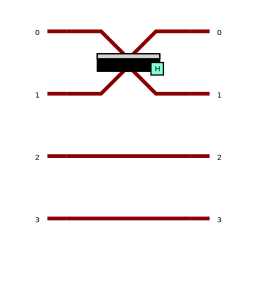

In [2]:
c = Circuit(4) // (0, BS.H())
pdisplay(c)

On s'attend à avoir :
$$
\DeclareMathOperator{\H}{H}
\DeclareMathOperator{\I}{I}
$$

$$
|0\rangle \otimes |1\rangle \rightarrow \begin{cases} 
    \text{En haut : } |0\rangle \longrightarrow \H \longrightarrow \frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle \\
    \text{En bas :  } |1\rangle \longrightarrow \I \longrightarrow |1\rangle
\end{cases} \rightarrow \left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right)\otimes|1\rangle 
$$

Ce qui donne l'état : 
$$
\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right)\otimes|1\rangle = \frac{1}{\sqrt{2}}|01\rangle+\frac{1}{\sqrt{2}}|11\rangle
$$

En pratique on détermine la porte logique $U$, on a $U = H\otimes I$, donc :
$$
U = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1& -1\end{pmatrix} \otimes \begin{pmatrix} 1&0 \\ 0& 1 \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\times\begin{pmatrix} 1&0 \\ 0& 1 \end{pmatrix}&1\times\begin{pmatrix} 1&0 \\ 0& 1 \end{pmatrix}\\1\times\begin{pmatrix} 1&0 \\ 0& 1 \end{pmatrix}&-1\times\begin{pmatrix} 1&0 \\ 0& 1 \end{pmatrix} \end{pmatrix}= \frac{1}{\sqrt{2}}\begin{pmatrix} 1&0&1&0\\0&1&0&1\\1&0&-1&0\\0&1&0&-1\end{pmatrix}
$$

Ce qui donne avec notre entrée :
$$
|01\rangle = \begin{pmatrix} 0\\1\\0\\0\end{pmatrix}, 
$$
$$
\frac{1}{\sqrt{2}}\begin{pmatrix} 1&0&1&0\\0&1&0&1\\1&0&-1&0\\0&1&0&-1\end{pmatrix} \begin{pmatrix} 0\\1\\0\\0\end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix} 0\\1\\0\\1\end{pmatrix} = \frac{1}{\sqrt{2}} |01\rangle + \frac{1}{\sqrt{2}} |11\rangle
$$

Qui correspond bien à l'attendu.

*Si vous souhaitez avoir une explication plus détaillée, vous pouvez regarder ce cours, proposé par IBM : https://learning.quantum.ibm.com/course/basics-of-quantum-information/multiple-systems*.

## L'intrication quantique

Une propriété très intéressante des qubits, est qu'ils peuvent agir indépendemment, mais aussi être **intriqués**. C'est-à-dire dépendant l'un de l'autre. Cela permet par exemple, d'agir sur un qubit, et d'obtenir des informations sur le deuxième. 

Si l'on prend l'état intriqué $|\psi\rangle=\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$, et que l'on mesure le premier qubit (on a une chance sur deux d'avoir $0$ et réciproquement $1$), l'état du deuxième qubit est entièrement déterminé, sans que l'on ait eu à le mesurer ! En effet, si l'on mesure $0$ pour le premier qubit, alors le deuxième est *forcément* aussi à $0$.

Un contre-exemple est l'état $|\psi\rangle=\frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)$, mesurer le premier qubit ne donne aucune information sur le deuxième, les deux qubits sont **indépendants**.

## La porte *Controlled-NOT* (CNOT)

La porte phare de l'intrication quantique est la porte contrôlée *NOT* (ou *CNOT* ou *cX*). Elle agit sur 2 qubits, et n'**effectue l'opération *NOT* sur le second qubit que lorsque le premier qubit est $|1\rangle$ et sinon le laisse inchangé**. Sa matrice est la suivante : 

$$
\DeclareMathOperator{\CNOT}{CNOT}
$$

$$
\CNOT = \begin{pmatrix}1&0&0&0\\0&1&0&0\\0&0&0&1\\0&0&1&0\end{pmatrix}
$$
Ou encore : 
$$
\CNOT = 
\begin{cases}
    |00 \rangle \rightarrow |00 \rangle \\
    |01 \rangle \rightarrow |01 \rangle \\
    |10 \rangle \rightarrow |11 \rangle \\
    |11 \rangle \rightarrow |10 \rangle 
\end{cases}
$$

Son implémentation avec des photons est assez technique, et elle cache des problèmes liés à notre façon d'encoder des qubits. Nous allons donc nous contenter de la définition proposée par Quandela, afin de pouvoir utiliser cette porte dans nos circuits.

In [3]:
from perceval.components import catalog
cnot = catalog["klm cnot"].build_circuit()
# https://github.com/Quandela/Perceval/blob/main/perceval/components/core_catalog/klm_cnot.py

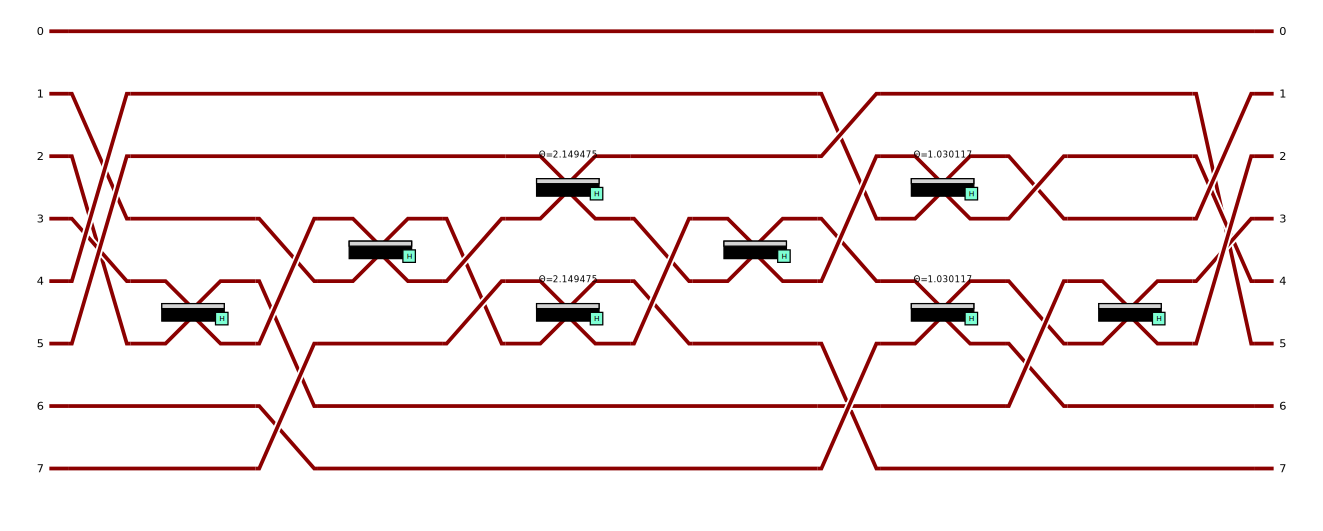

In [4]:
pdisplay(cnot)

## Un dernier point pour la route

Comme vous l'avez vu, la porte *CNOT* définie au-dessus **comporte 6 rails au lieu des 4 attendus**. En fait, c'est ici que se cache la particularité technique liée à la photonique. Pour que notre encodage fonctionne, il faut absolument que **la somme des photons dans une paire de rail soit égale à 1**. 

Par exemple pour l'état $|01\rangle$, on a $1$ photon dans le premier rail, $0$ dans le second et dans le troisième, et $1$ dans le quatrième. Si l'on se retrouve avec $1$ photon dans le second rail et $1$ photon dans le troisième rail à la fin, l'on sait que l'on a l'état $|10\rangle$. Mais que se passe-t-il si l'on obtient $2$ photons dans le premier rail et $0$ dans les autres ? On ne sait pas, cela ne correspond à aucun état. En fait, cela à du sens physiquement parlant, mais pas informatiquement parlant, on arrive plus à mettre des qbits sur notre état photonique. 

Pour pallier ce problème, on rajoute des états de contrôle, qui vont annuler certains résultats. Dans notre cas, tout sera fait automatiquement grâce à des *heralded gates* et des *ancilla states*.

### Pour résumer :
- On laisse les *heralded gates* et les *ancilla states* s'occuper des problèmes.
- Si on se retrouve avec un nombre incohérent de photons à la fin de notre expérience, cela ne sert à rien de chercher compliqué, l'expérience est invalide, il faut revoir le circuit.

Afin de gérer les *heralded gates* et les *ancilla states*, nous allons travailler directement avec les processeurs. 

*Plus d'information ici : https://perceval.quandela.net/docs/notebooks/Tutorial.html#3.-Two-qubit-gates*

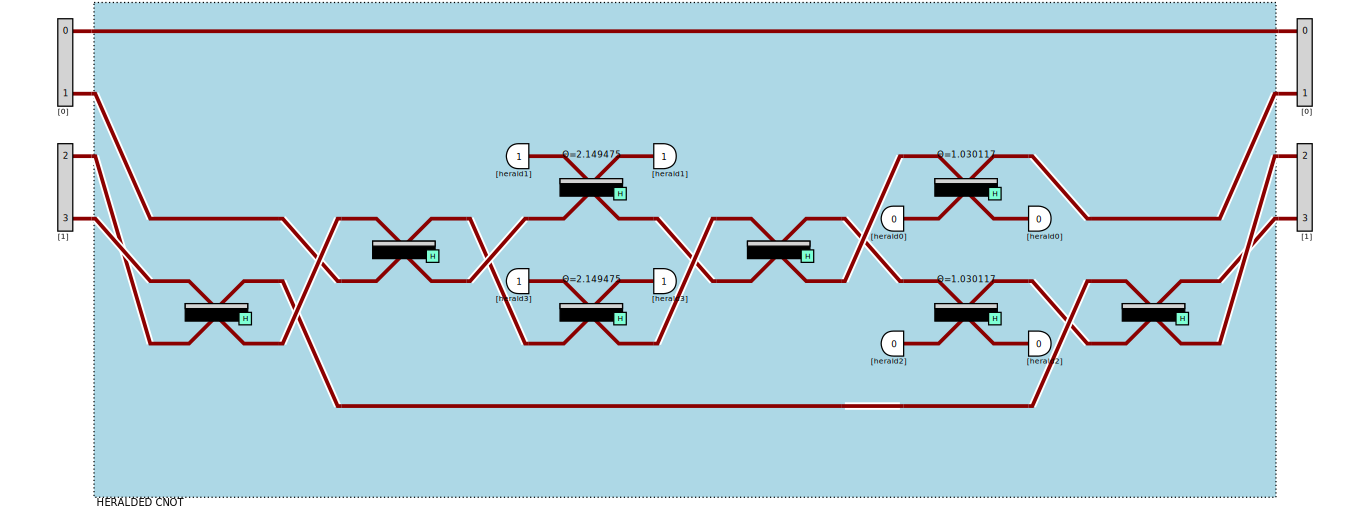

In [5]:
p = Processor("Naive", cnot)
p.min_detected_photons_filter(0)
p.add_herald(4, 0)
p.add_herald(5, 1)
p.add_herald(6, 0)
p.add_herald(7, 1)
p.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))
p.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))
pdisplay(p, recursive=True)

In [6]:
measure2p(p)
measure2p(p, input_state=qubits["10"])
measure2p(p, input_state=qubits["01"])
measure2p(p, input_state=qubits["11"])

Avec l'entrée : 00
> 00: 1.0
Avec l'entrée : 10
> 11: 1.0
Avec l'entrée : 01
> 01: 1.0
Avec l'entrée : 11
> 10: 1.0


## À vous de jouer ! 

On a vu comment préparer un qubit dans n'importe quel état quantique. On va maintenant pouvoir passer à la mise en place d'états à deux qubits !

Pour commencer, on peut essayer de préparer ce qu'on appelle les **états de Bell.** Ils sont très utilisés, car ils correspondent à des **états intriqués** et ils sont relativement facile à manipuler. Ils correspondent à la base :

$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
$$
$$
|\Phi^-\rangle = \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle)
$$
$$
|\Psi^+\rangle = \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle)
$$
$$
|\Psi^-\rangle = \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle)
$$

Essayons de préparer l'état $|\Phi^+\rangle$. Un raisonnement possible est le suivant : on cherche à avoir un état superposé, il faudra donc une porte d'Hadamard ou équivalent, on a aussi besoin d'états intriqués, il faudra donc une porte $\CNOT$. Cela donne en pratique : 

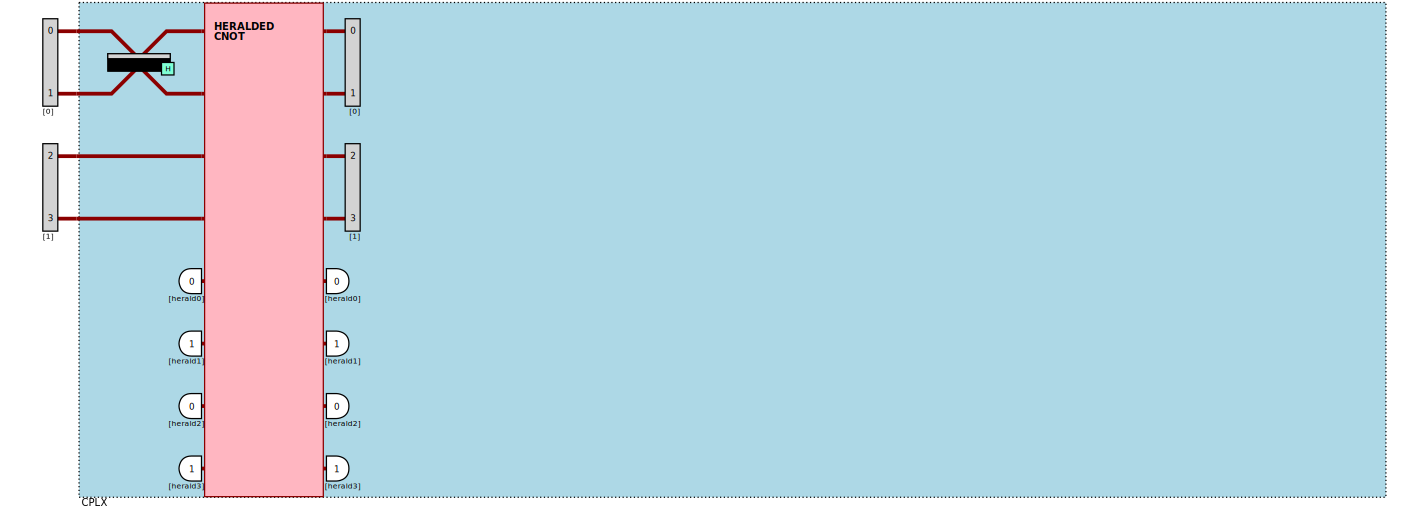

In [7]:
phi_plus = Circuit(8).add(0, BS.H()).add(0, cnot)

# Préparation du processeur
p_plus = Processor("Naive", phi_plus)  # Étape 1 : création du processeur avec le bon circuit
p_plus.min_detected_photons_filter(0)       # Étape 2 : création du filtre pour annuler les expériences ratées
p_plus.add_herald(4, 0)                     # Étape 3 : ajouts d'heralds sur les rails 4, 5, 6, 7 
p_plus.add_herald(5, 1)                     
p_plus.add_herald(6, 0)                     
p_plus.add_herald(7, 1)                     
p_plus.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))  # (Étape 4) : On peut, cela n'est pas obligatoire
p_plus.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))  #      préciser que l'on est en encodage par rail. 
pdisplay(p_plus, recursive=True)            # Étape finale : on admire le résultat/ on pleure si ça marche pas

In [8]:
measure2p(p_plus)

Avec l'entrée : 00
> 00: 0.5
> 11: 0.5


On peut aussi tricher avec :

In [9]:
e = pcvl.utils.stategenerator.StateGenerator(encoding=pcvl.Encoding.DUAL_RAIL)
b = e.bell_state("phi-")
print(b)

-sqrt(2)/2*|0,1,0,1>+sqrt(2)/2*|1,0,1,0>


## Étape 1 : Créations d'états quantiques

**1.a)** Créez l'état :
$$
|\psi\rangle = |11\rangle
$$

Sachant que l'on part toujours de notre état de base, ici $|00\rangle$. Les qubits sont accessibles via le dictionnaire `qbits` pour les tests, même si l'entrée par défault est déjà $|00\rangle$.

*Il y a plusieurs façons de procéder. Tout est accepté.*

<h2 style="color:green"> Solution étape 1 : </h2>

Une possibilité est la suivante : 
$$
|00\rangle \xrightarrow{X \text{qubit 0}} |10\rangle \xrightarrow{\CNOT}  |11\rangle
$$

On aurait aussi pu directement appliquer deux fois la porte *NOT* : 
$$
|00\rangle \xrightarrow{X \text{qubit 0}} |10\rangle \xrightarrow{X \text{qubit 1}}   |11\rangle
$$

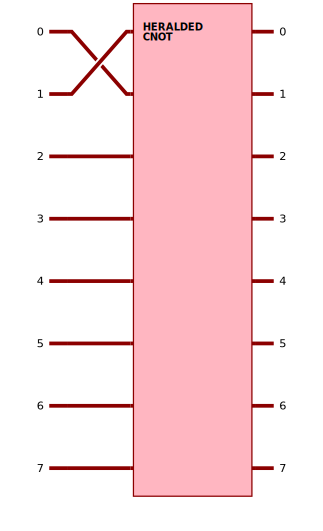

In [10]:
step_one = Circuit(8).add(0, PERM([1, 0])).add(0, cnot)
step_one_double_not = Circuit(4).add(0, PERM([1, 0, 3, 2])) 

pdisplay(step_one)

Si vous n'avez pas utilisé de porte *CNOT*, vous pouvez vérifier avec : 

In [11]:
if len(step_one.depths()) == 4:
    analyze(step_one)
    print(f"Résultat : {amplitudes(step_one)}")
    print("Solution : {'00': 0j, '01': 0j, '10': 0j, '11': (1+0j)}")

Si vous avez utilisé un *CNOT*, il faut mettre en place un processeur : 

In [12]:
if len(step_one.depths()) == 8:
    p_step_one = Processor("Naive", step_one)
    p_step_one.min_detected_photons_filter(0)
    p_step_one.add_herald(4, 0)
    p_step_one.add_herald(5, 1)
    p_step_one.add_herald(6, 0)
    p_step_one.add_herald(7, 1)
    p_step_one.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))
    p_step_one.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))
    pdisplay(p_step_one, recursive=True)

In [13]:
measure2p(p_step_one)
print("Solution :\n> 11: 1.0")

Avec l'entrée : 00
> 11: 1.0
Solution :
> 11: 1.0


**1.b)** Créez l'état : 
$$
|\psi\rangle = -\cos\frac{\pi}{6}|00\rangle-\sin\frac{\pi}{6}|11\rangle
$$

<h2 style="color:green"> Solution étape 1 bis : </h2>
On peut tout d'abord chercher à appliquer la rotation au rail 0 : 
$$
|00\rangle \xrightarrow{Ry ~\text{qubit 0}} -\cos\frac{\pi}{6}|00\rangle-\sin\frac{\pi}{6}|10\rangle
$$

Il suffit alors d'appliquer un *CNOT* pour atteindre le résultat : 
$$
 -\cos\frac{\pi}{6}|00\rangle-\sin\frac{\pi}{6}|10\rangle\xrightarrow{CNOT}-\cos\frac{\pi}{6}|00\rangle-\sin\frac{\pi}{6}|11\rangle
 $$

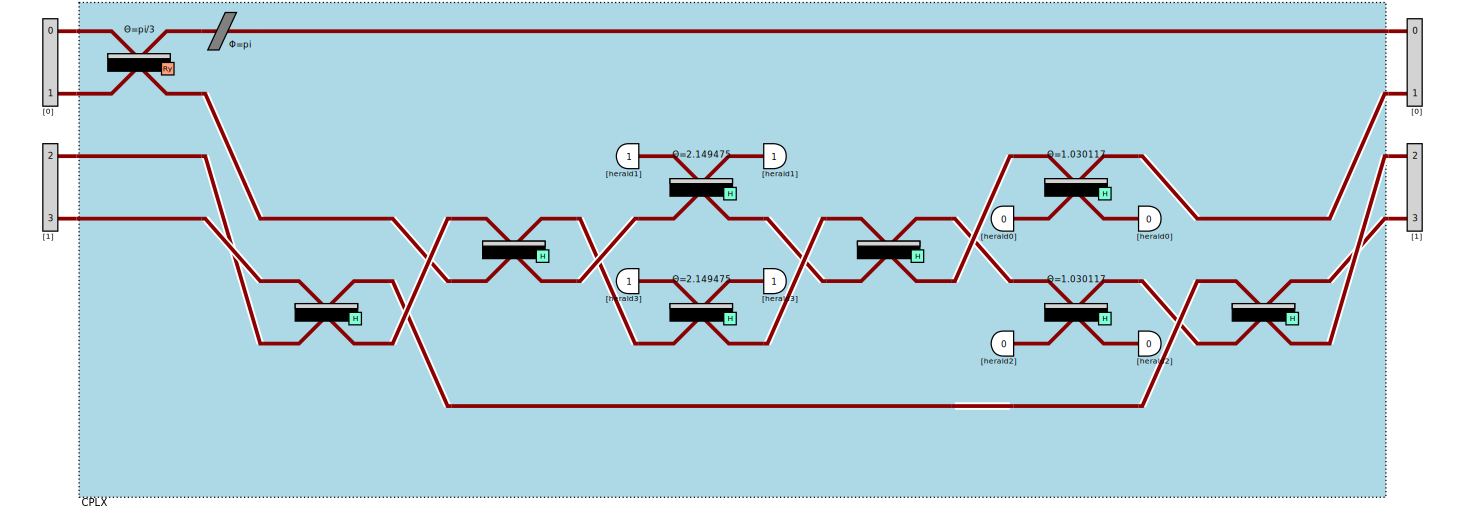

In [14]:
# Il faut faire attention aux signes et au facteur 2 lié à l'implémentation de `BS.Ry` : 
step_one_more = Circuit(8) // BS.Ry(pi/3) // (0, PS(pi)) // (0, cnot)

p_step_one_more = pcvl.Processor("Naive", step_one_more)
p_step_one_more.min_detected_photons_filter(0)
p_step_one_more.add_herald(4, 0)
p_step_one_more.add_herald(5, 1)
p_step_one_more.add_herald(6, 0)
p_step_one_more.add_herald(7, 1)
p_step_one_more.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))
p_step_one_more.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))
pdisplay(p_step_one_more, recursive=True)

In [15]:
measure2p(p_step_one_more)

Avec l'entrée : 00
> 00: 0.75
> 11: 0.25


## Étape 2 : Les états de Bell

Une fois qu'on a réussi à créer les états de Bell, encore faut-il savoir les mesurer pour pouvoir les utiliser. De la même manière que précédemment, pour mesurer dans une base $\mathcal{B}$ quelconque, on va créer la matrice de passage de $\mathcal{B}$ à $\mathcal{B}_c$, notre base canonique, puis on mesurera dans cette même base connue. 

Combinez différentes portes pour obtenir la porte de changement de base, de la base de Bell à la base canonique. Les tests sont en dessous.

<h2 style="color:green"> Solution étape 2 : </h2>
Soit on peut inverser la matrice de passage de la base canonique à la base de Bell pour obtenir la matrice qui retourne dans la base canonique. Soit on peut simplement voir que <i>H</i> est sa propre inverse et que <i>CNOT</i> est aussi sa propre inverse. Ce qui donne donc pour $|00\rangle$ : 
$$
|00\rangle \xrightarrow{H ~\text{qubit 0}} \frac{1}{\sqrt{2}} |00\rangle + \frac{1}{\sqrt{2}} |10\rangle \xrightarrow{CNOT} \frac{1}{\sqrt{2}} |00\rangle + \frac{1}{\sqrt{2}} |11\rangle \xrightarrow{CNOT} \frac{1}{\sqrt{2}} |00\rangle + \frac{1}{\sqrt{2}} |10\rangle\xrightarrow{H ~\text{qubit 0}} |00\rangle
$$

In [16]:
step_two = Circuit(8, "Passage Bell -> Canonique") // (0, cnot) // (0, BS.H())

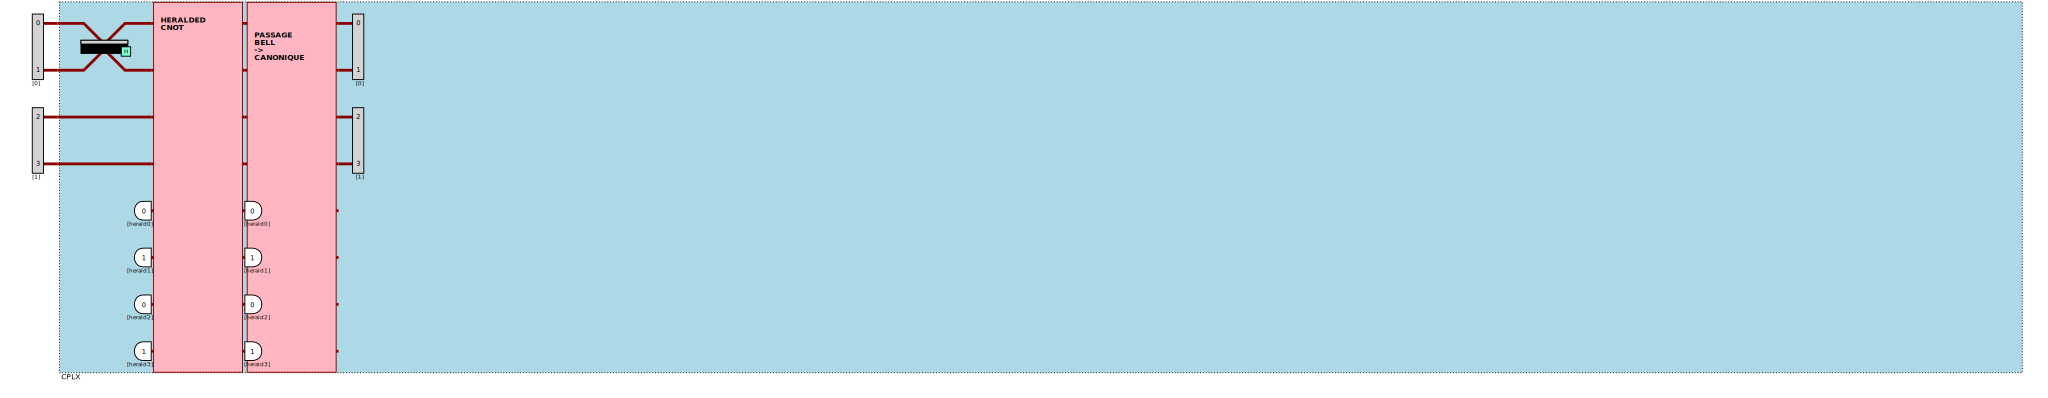

In [17]:
test_passage = Circuit(8).add(0, BS.H()).add(0, cnot).add(0, step_two)
p_test_passage = pcvl.Processor("Naive", test_passage)
p_test_passage.min_detected_photons_filter(0)
p_test_passage.add_herald(4, 0)
p_test_passage.add_herald(5, 1)
p_test_passage.add_herald(6, 0)
p_test_passage.add_herald(7, 1)
p_test_passage.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))
p_test_passage.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))
pdisplay(p_test_passage, recursive=True)

Le circuit de test passe dans la base de Bell, puis retourne dans la base canonique. On s'attend donc à trouver l'identité (à quelques arrondis près).

In [18]:
measure2p(p_test_passage)

Avec l'entrée : 00
> 00: 0.96
> 01: 0.02
> 10: 0.02
> 11: 0.0


In [19]:
measure2p(p_test_passage, qubits["01"])

Avec l'entrée : 01
> 00: 0.02
> 01: 0.96
> 10: 0.0
> 11: 0.02


In [20]:
measure2p(p_test_passage, qubits["10"])

Avec l'entrée : 10
> 00: 0.02
> 01: 0.0
> 10: 0.96
> 11: 0.02


In [21]:
measure2p(p_test_passage, qubits["11"])

Avec l'entrée : 11
> 00: 0.0
> 01: 0.02
> 10: 0.02
> 11: 0.96


*Il était aussi possible de faire le circuit sur 12 rails pour ne pas réutiliser les* heralds *et avoir des sorties exactes, mais ce n'était pas demandé*.

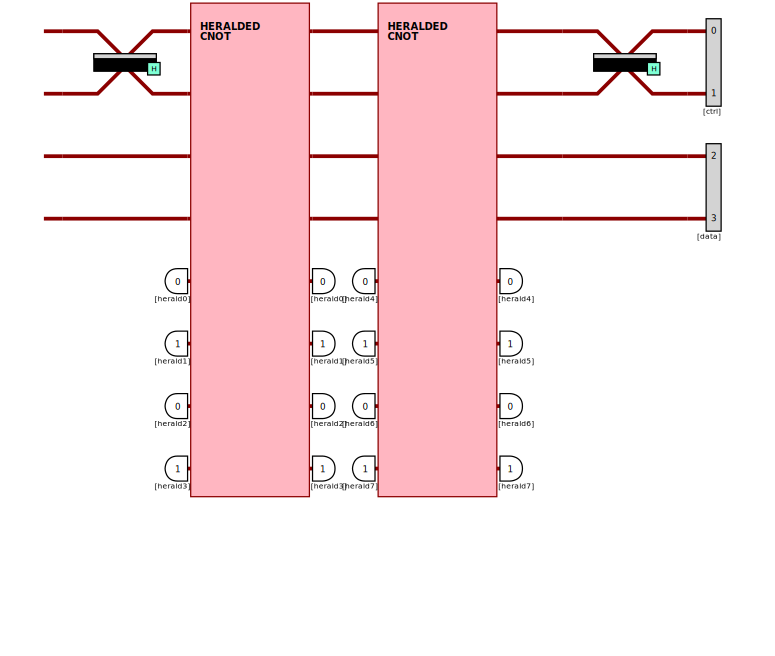

In [22]:
# J'utilise directement le processeur pour ne pas avoir à gérer les heralds à la main : 
CNOT = catalog['klm cnot'].build_processor()
q1, q2 = [0,1], [2,3]

p_better = pcvl.Processor("SLOS",4)
p_better.add(0, BS.H())
p_better.add(q1+q2, CNOT)
p_better.add(q1+q2, CNOT)
p_better.add(0, BS.H())
pcvl.pdisplay(p_better, recursive=False)

In [23]:
measure2p(p_better, qubits["00"])

Avec l'entrée : 00
> 00: 1.0


In [24]:
measure2p(p_better, qubits["01"])

Avec l'entrée : 01
> 01: 1.0


In [25]:
measure2p(p_better, qubits["10"])

Avec l'entrée : 10
> 10: 1.0


In [26]:
measure2p(p_better, qubits["11"])

Avec l'entrée : 11
> 11: 1.0


## Étape 3 : Trivial ? 

Créez l'état : 
$$
|\psi\rangle = \frac{1}{\sqrt{3}}(|01\rangle + |10\rangle + |11\rangle)
$$

<h2 style="color: green"> Solution étape 3 :</h2>
Une possibilité pour cette étape est de faire une première division $\left(\frac{1}{\sqrt{3}}/\frac{2}{\sqrt{3}}\right)$ puis de faire une deuxième division, cette fois conditionnelle $\left(\frac{1}{\sqrt{3}}/\frac{1}{\sqrt{3}}/\frac{1}{\sqrt{3}}\right)$. Pour faire cette deuxième division conditionnelle, il nous faut une porte de Hadamard qui s'applique sur le deuxième qubit uniquement si le premier est à 1, une porte de Hadamard controlée (<i>CH</i>). 

Pour construire cette porte à partir des portes de base, on peut chercher la rotation $R_y(\theta)$ telle que :
$$
\DeclareMathOperator{\PS}{PS}
$$
$$
R_y(\theta)\PS(\pi)R_y(-\theta) = \H
$$
Avec :
$$
\PS(\theta) = \begin{pmatrix}
1 & 0 \\
0 & e^{i\theta}
\end{pmatrix}
$$
car cela donne : 
$$
\begin{cases}
R_y(\theta)\PS(\pi)R_y(-\theta) = \H, \quad\text{si la CNOT est activée} \\
R_y(\theta)I R_y(-\theta) = I, \quad\text{sinon}
\end{cases}
$$

Il suffit donc de trouver $\theta$ avec :
$$
R_y(\theta) = \begin{pmatrix}
\cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\
\sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
\end{pmatrix}
$$
Ce qui donne : 
$$
R_y(\theta)\PS(\pi)R_y(-\theta) = \begin{pmatrix}
\cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\
\sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
\end{pmatrix}
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
\begin{pmatrix}
\cos{\frac{\theta}{2}} & \sin{\frac{\theta}{2}} \\
- \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
\end{pmatrix}
=
\begin{pmatrix}
\cos{\theta} & \sin{\theta} \\
\sin{\theta} & -\cos{\theta}
\end{pmatrix}
= H
$$
D'où : 
$$
\theta = \frac{\pi}{4}
$$

(Version avec une meilleure explication : https://quantumcomputing.stackexchange.com/questions/15734/how-to-construct-a-controlled-hadamard-gate-using-single-qubit-gates-and-control)

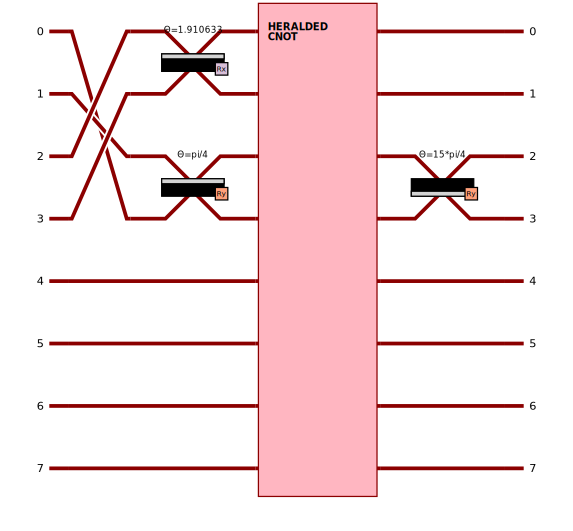

In [27]:
# À quelques permutations près :
step_three = (Circuit(8).add(0, PERM([3, 2, 0, 1])).add(0, BS(BS.r_to_theta(1/3))).add(2, BS.Ry(pi/4)).add(0, cnot).add(2, BS.Ry(-pi/4)))

pdisplay(step_three)

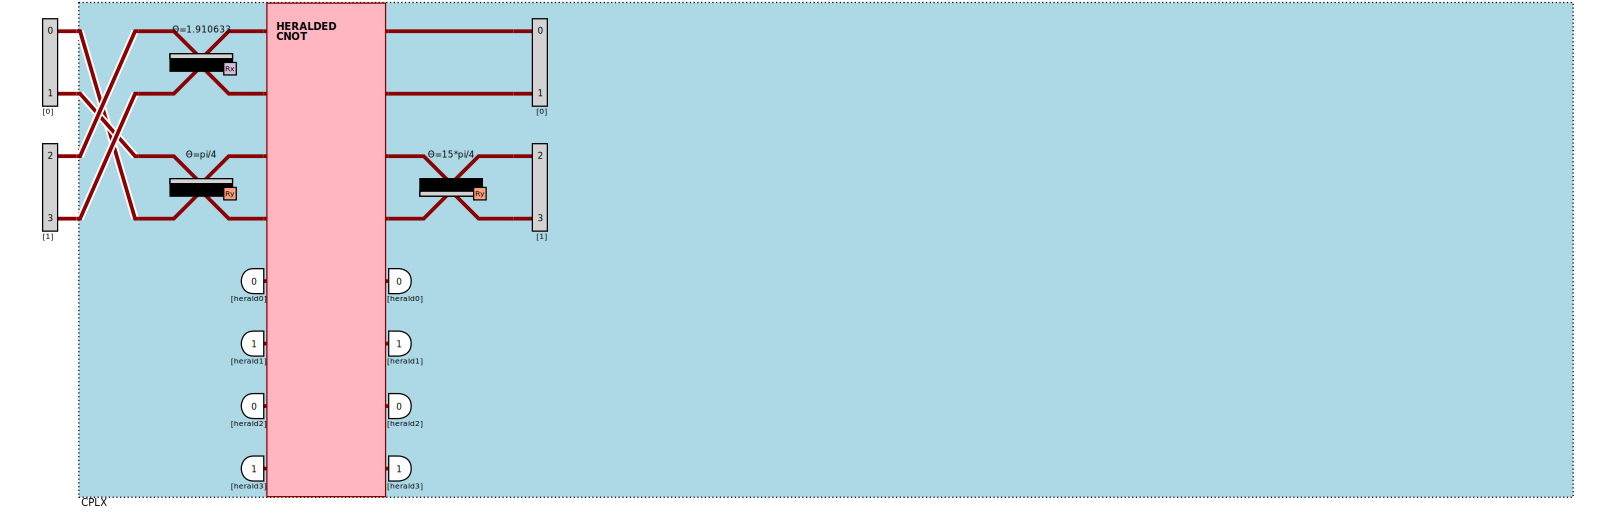

In [28]:
p_step_three = Processor("Naive", step_three)
p_step_three.min_detected_photons_filter(0)
p_step_three.add_herald(4, 0)
p_step_three.add_herald(5, 1)
p_step_three.add_herald(6, 0)
p_step_three.add_herald(7, 1)
p_step_three.add_port(0, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "0"))
p_step_three.add_port(2, pcvl.Port(pcvl.Encoding.DUAL_RAIL, "1"))
pdisplay(p_step_three, recursive=True)

In [29]:
measure2p(p_step_three)

Avec l'entrée : 00
> 01: 0.33
> 10: 0.33
> 11: 0.33


## Récupération du drapeau

In [30]:
def circuit_to_list(circuit: Circuit) -> List[List[Tuple[float, float]]]:
    return [[(x.real, x.imag) for x in l] for l in np.array(circuit.compute_unitary())]

d = {
    "step_one": circuit_to_list(step_one),
    "step_one_more": circuit_to_list(step_one_more),
    "step_two": circuit_to_list(step_two),
    "step_three": circuit_to_list(step_three)
}

In [31]:
import requests as rq

URL = "https://perceval.challenges.404ctf.fr"
rq.get(URL + "/healthcheck").json()

{'message': 'Statut : en pleine forme !'}

In [32]:
rq.post(URL + "/challenges/3", json=d).json()

{'message': 'GG ! Voici le drapeau : 404CTF{d_Un3_tR1v14l1t3_AbS0lu3}'}